# Player Positions
Baseball has nine main fielding positions: Pitcher, Catcher, First Base, Second Base, Shortstop, Third Base, Right Field, Left Field, and Center Field.

While players specialize by position, it is also not unusual for them to switch among positions throughout their careers. For example, the outfield positions require largely overlapping skills. In addition, pitcher and catcher are highly specialized, and usually require specialization throughout an entire career.

In this notebook, I will demonstrate the use of clustering to identify groups of positions that players often play together.

### Setup
In this section, we connect to the data. This data was downloaded from a Kaggle competition on the history of baseball. It is a sqlite file.

In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect("C:/Users/Stephen Spitz/Desktop/programming/MachineLearning/baseball/database.sqlite")

### Pull the Data
In this section, we pull the data. We use a SQL query on the database.

For each player in the data set, we find the total number of games they appeared in, and the percentage of those games for which they appeared at each position. Note, the percentages will not necessarily sum to 1 because a player may appear at multiple positions in a single game.

In [149]:
import pandas as pd

# Positions
pos_str = ["1b", "2b", "ss", "3b", "p", "rf", "cf", "lf", "c"]
pos_cols = ",".join([f"cast(sum(g_{p}) as int) as g_{p}" for p in pos_str])
pos_pct_cols = ",".join([f"cast(sum(g_{p}) as float) / cast(sum(g_all) as float) as g_{p}_pct" for p in pos_str])

# SQL Query
query = f"""
select player_id, 
       sum(g_all) as g_all, 
       {pos_cols}, 
       {pos_pct_cols},
       count(distinct(case when g_all > 0 then year end)) as seasons, 
       max(year) as last_season
from appearances
group by player_id
"""

# Run query on database
appearances = pd.read_sql_query(query, con)


#appearances['pos'] = appearances[[f"g_{pos}" for pos in pos_str]].idxmax(axis=1)
#appearances['pos'] = appearances['pos'].replace({f"g_{pos}": pos for pos in pos_str})

#excluded_players = pd.read_sql_query("select distinct player_id from appearances where g_all = ''", con)['player_id'].values
#appearances = appearances[~appearances["player_id"].isin(excluded_players)]

### Analysis
In this section, we perform the analysis.

First, we project the data into two dimensions to observe any clustering. We accomplish this with tSNE, a manifold method.

This method creates clear position clusters.

<Axes: xlabel='0', ylabel='1'>

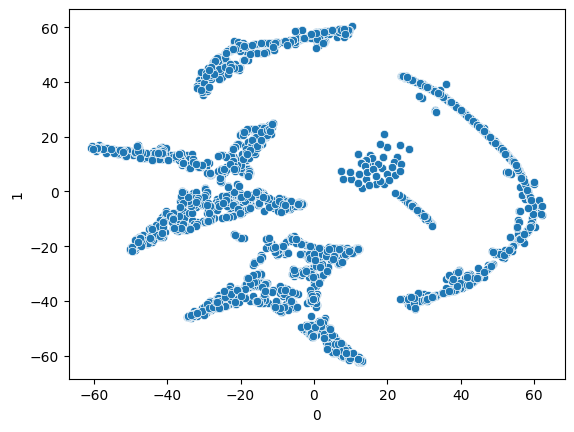

In [150]:
from sklearn.manifold import TSNE

tsne = TSNE()

out = tsne.fit_transform(appearances[appearances['seasons'] >= 10][["g_1b_pct", "g_2b_pct", "g_3b_pct", "g_ss_pct", "g_p_pct", "g_lf_pct", "g_rf_pct", "g_cf_pct", "g_c_pct"]])

sns.scatterplot(data=pd.DataFrame(out), x=0, y=1)

To sort the players into clusters, we use a clustering algorithm on the projected data. KMeans would not work well here because the clusters are irregular in shape.

Instead, we use DBSCAN, which will work well for this type of density based clustering. The hyperparameter, eps has to be adjusted to control the size of the clusters. By selecting a good value, we see each cluster is clearly separated.

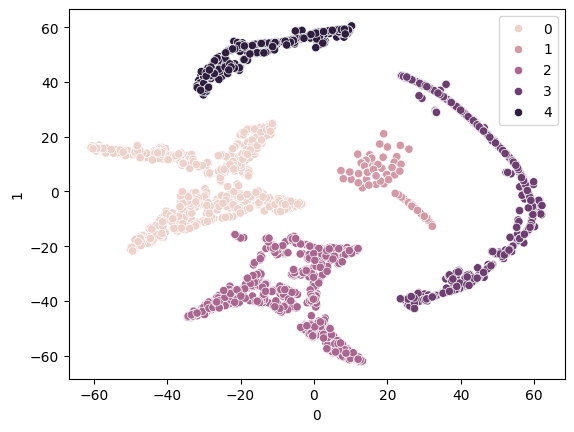

In [152]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=6)

dbscan.fit(out)

_ = sns.scatterplot(data=pd.DataFrame(out), x=0, y=1, hue=dbscan.labels_)

To understand what the clusters mean, we average the percentage played across each position for each cluster. We see the players cluster nicely into 5 types of positions:
- 0: Outfield and First Base
- 1: Pitcher
- 2: Second Base, Shortstop, Thirdbase
- 3: Pitcher with some other positions
- 4: Catcher

This confirms our understanding. However, we have the unexpected finding that First Base is closer to an Outfielder than an Infielder.

In [155]:
test = appearances[appearances["seasons"] >= 10]
test["label"] = dbscan.labels_

test.groupby("label")[["g_1b_pct", "g_2b_pct", "g_3b_pct", "g_ss_pct", "g_p_pct", "g_lf_pct", "g_rf_pct", "g_cf_pct", "g_c_pct"]].mean()

C:\Users\Stephen Spitz\AppData\Local\Temp\ipykernel_13976\3039375171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["label"] = dbscan.labels_


,g_1b_pct,g_2b_pct,g_3b_pct,g_ss_pct,g_p_pct,g_lf_pct,g_rf_pct,g_cf_pct,g_c_pct
label,,,,,,,,,
0,0.190687,0.004424,0.009005,0.002448,0.002256,0.234058,0.222168,0.221774,0.003198
1,0.000018,0.000004,0.000000,0.000000,1.010391,0.000007,0.000051,0.000002,0.000004
2,0.037350,0.284918,0.280680,0.287545,0.001028,0.025744,0.016573,0.011486,0.002735
3,0.001481,0.000722,0.001379,0.000878,0.958235,0.002700,0.004812,0.002478,0.000062
4,0.028528,0.001786,0.007944,0.001463,0.000156,0.006520,0.008372,0.002016,0.864415


Finally, we show the cluster plot, labeling each cluster.

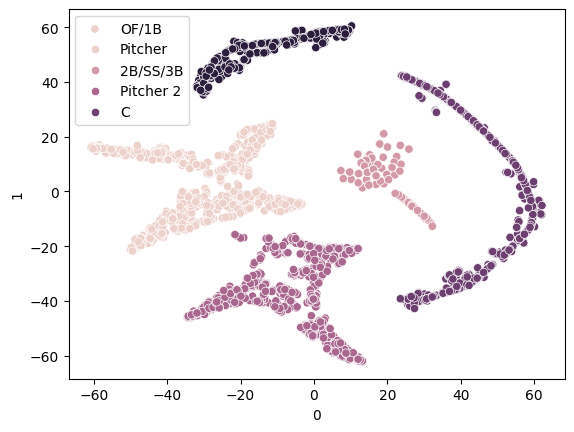

In [159]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=6)

dbscan.fit(out)

_ = sns.scatterplot(data=pd.DataFrame(out), x=0, y=1, hue=dbscan.labels_)
plt.legend(loc='upper left', labels=['OF/1B', 'Pitcher', '2B/SS/3B', 'Pitcher 2', 'C'])